Here Kolomgorov-Smirinov test is used to investigate two cases:<br>
1. What are the discriminative properties of the features if dataset contain only RMS calculated over signals from one single session. <br>
2. What are the discriminative properties of the features if dataset contain  RMS calculated over signals from all sessions.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from scipy import stats
import pandas as pd
import numpy as np

In [ ]:
def create_paths(session=False, reduced=False, random_selection=False):
  """"This function is here just to provide easier usage of different combinations and paths"""
  if session: 
    if reduced:
      folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_200ms_s'+str(session)
    else:
      folder='/content/drive/Shared drives/Nikolina/RMS data/1D features/Intra-session/RMS_features_1s_s'+str(session)
      
    paths=[folder+'_train.csv',folder+'_valid.csv',folder+'_test.csv']
    grid_search_res='drive/Shared drives/Nikolina/29.5. Results/gs_session'+str(session)
  else:
    paths=['','','']
    if random_selection:
      if reduced:
        paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_rs_200ms.csv'
        paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_rs_200ms.csv'
        paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_rs_200ms.csv'
        
      else:
        paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_rs_1s.csv'
        paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_rs_1s.csv'
        paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_rs_1s.csv'
    else:
      if reduced:
        paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_200ms.csv'
        paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_200ms.csv'
        paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_200ms.csv'
        
      else:
        paths[0]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_train_1s.csv'
        paths[1]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_valid_1s.csv'
        paths[2]='/content/drive/Shared drives/Nikolina/RMS data/1D features/Inter-session/RMS_test_1s.csv'

  return paths


def read_data(paths,print_=False):
  """Reads data from the paths and returns it."""
  e=65
  ch=np.arange(0,56,1)
  df = pd.read_csv(paths[0])
  in_train=df.values[ch,:].T
  out_train=df.values[56:e,:].T

  #valid
  df = pd.read_csv(paths[1])
  in_valid=df.values[ch,:].T
  out_valid=df.values[56:e,:].T

  #test
  df = pd.read_csv(paths[2])
  in_test=df.values[ch,:].T
  out_test=df.values[56:e,:].T

  if print_:
    print('train data: ', np.shape(in_train),np.shape(out_train))
    print('validation data: ', np.shape(in_valid),np.shape(out_valid))
    print('test data: ', np.shape(in_test),np.shape(out_test))
  
  return in_train, out_train, in_valid, out_valid, in_test, out_test

In [ ]:
def plot_2D(values1, values2, values3, values4, title_, labels, ax=None, xlim_=None, ylim_=None,lx=None,ly=None):
    """The function makes 2D scatter plot of features.
    values1=features that will be shown on x axis - class 1
    values2=features that will be shown on y axis - class 1
    values3=features that will be shown on x axis - class 2
    values4=features that will be shown on y axis - class 2
    title= title in string form,
    labels=['label1','labels2']"""
    
    if ax:
        ax.set_title(title_,fontsize=20)
        labeled = False
        for i in range(len(values1)):
            ax.plot(values1[i],values2[i],'cD', label=labels[0] if not labeled else None)
            labeled = True

        labeled = False
        for i in range(len(values3)):
            ax.plot(values3[i],values4[i],'mD', label=labels[1] if not labeled else None)
            labeled = True
            
        
    else:
        plt.figure(figsize=(10,7))
        plt.title(title_,fontsize=20)
        labeled = False
        for i in range(len(values1)):
            lines=plt.plot(values1[i],values2[i],'cD', label=labels[0] if not labeled else None)
            labeled = True

        labeled = False
        for i in range(len(values3)):
            lines=plt.plot(values3[i],values4[i],'mD', label=labels[1] if not labeled else None)
            labeled = True
        if xlim_:
          plt.xlim(xlim_)
        if ylim_:
          plt.ylim(ylim_)
        plt.legend(prop={'size': 20})
        plt.xlabel(lx,fontsize=20)
        plt.ylabel(ly,fontsize=20)
        plt.show()



def create_one_vs_rest(labels, features, choice):
  labels1=labels[:,choice]
  labels2=np.zeros(len(labels1))
  labels2[np.where(labels1==0)[0]]=1

  features1=features[np.where(labels1==1)[0],:]
  features2=features[np.where(labels2==1)[0],:]

  return labels1, labels2, features1, features2

def create_binary(labels,features, choice1,choice2):
  """Creates binary representation from the labels, features and specific choices of the classes.
  Returns features and targets that describe only two deired classes."""
  labels1=labels[:,choice1]
  labels2=labels[:,choice2]

  features1=features[np.where(labels1==1)[0],:]
  features2=features[np.where(labels2==1)[0],:]

  return labels1, labels2, features1, features2


def check_discriminatory_properties(features1,features2,print_=False, plot_=False):
  """Perform a Kolomogorov-Smirinov test to check the extent to which two features are 
  linearly separable between two classes
  features[number of samples, number of features]
  features1 - class 1
  features2 - class 2"""
  KT=[]
  for i in range (0,np.shape(features1)[1]):
      f1=features1[:,i]
      f2=features2[:,i]
      ks_test=stats.ks_2samp(f1,f2)
      KT.append(ks_test[0])

      if print_:
        print('\nKS1, feature number: '+ str(i),'results', ks_test[0])
        print('p value, feature number: '+ str(i),'results', ks_test[1])

  if plot_:
    plt.figure(figsize=(20,8))
    plt.plot(KT)

  return KT, np.mean(KT), max(KT), np.argmax(KT)

Here we take data from all 5 sessions and perform KS test on each combination of two classes and for all the channels.<br>
Then mean and maximum values of KS score per combination is shown.<br>
Interpretation: the larger the score, the more descriptive the features. 

train data:  (10512, 56) (10512, 9)
validation data:  (3504, 56) (3504, 9)
test data:  (3504, 56) (3504, 9)
Features size for KS test:  (17520, 56)
Labels size for KS test:  (17520, 9)
Class 1 vs class 2, best feature: 27, score 0.21791599467078046
Class 1 vs class 3, best feature: 26, score 0.2684594348222425
Class 1 vs class 4, best feature: 10, score 0.1438748061924908
Class 1 vs class 5, best feature: 2, score 0.16361098450319053
Class 1 vs class 6, best feature: 46, score 0.19808802561765187
Class 1 vs class 7, best feature: 50, score 0.2550542388331814
Class 1 vs class 8, best feature: 50, score 0.2800568897235696
Class 1 vs class 9, best feature: 50, score 0.3638321905592327
Class 2 vs class 3, best feature: 43, score 0.1541025641025641
Class 2 vs class 4, best feature: 28, score 0.2352991452991453
Class 2 vs class 5, best feature: 2, score 0.1989423076923077
Class 2 vs class 6, best feature: 27, score 0.24615384615384617
Class 2 vs class 7, best feature: 36, score 0.27705128205

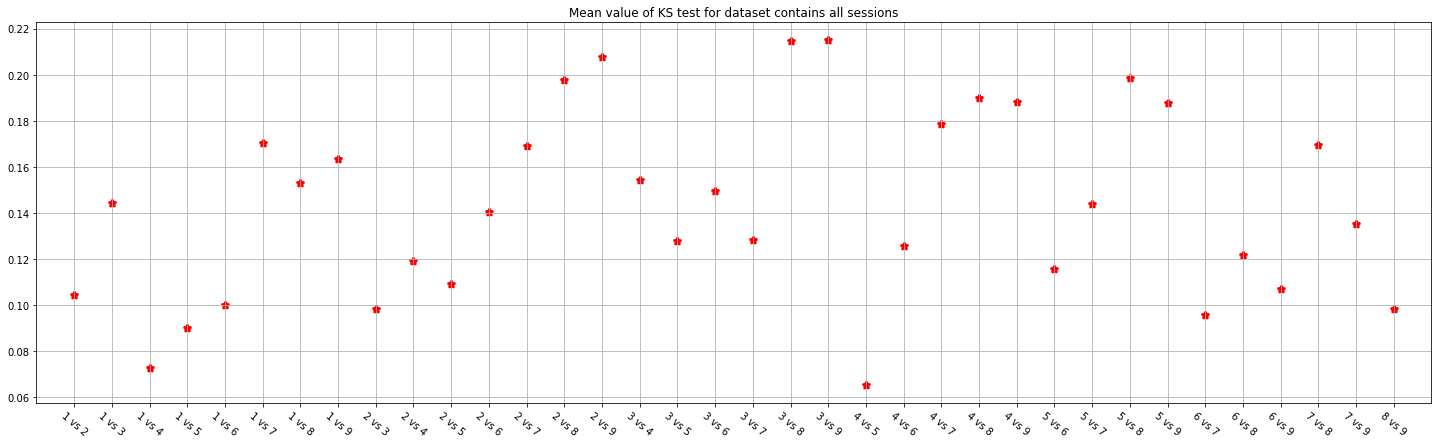

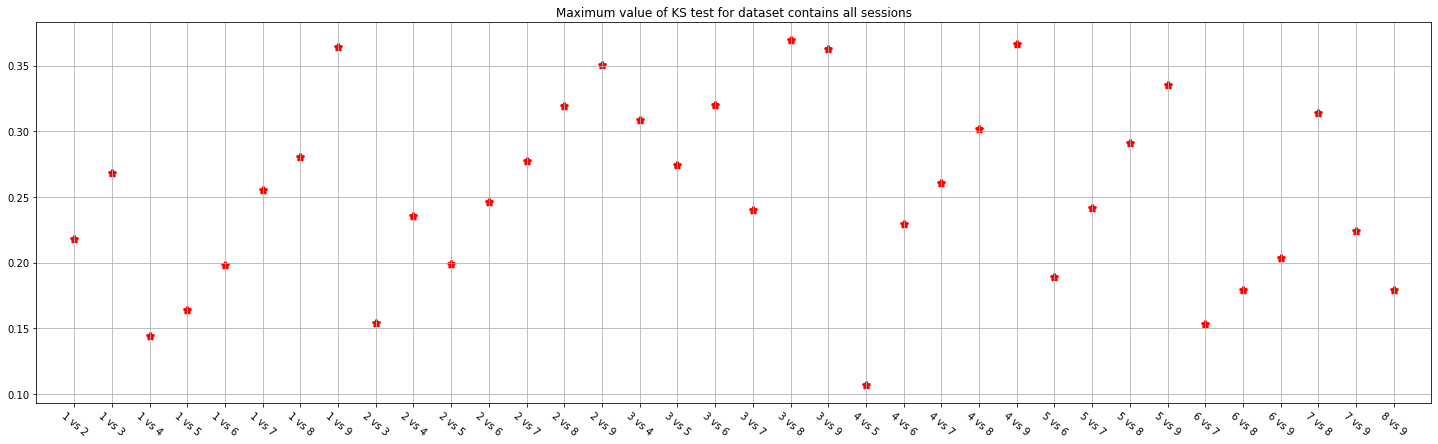

In [ ]:
session=False
reduced=False
random_selection=True
paths=create_paths(session, reduced, random_selection)
in_train, out_train, in_valid, out_valid, in_test, out_test=read_data(paths,print)

features=np.vstack((in_train,in_valid,in_test))
labels=np.vstack((out_train,out_valid,out_test))

print('Features size for KS test: ', np.shape(features))
print('Labels size for KS test: ', np.shape(labels))

M1=[]
M2=[]
xt=[]
cb=[]
for i in range(9):
  for j in range(9):
    if i!=j and [i,j] not in cb:
      cb.append([i,j])
      cb.append([j,i])
      l1,l2,f1,f2=create_binary(labels,features,i,j)
      KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=False, plot_=False)
      M1.append(mean_)#mean value of ks test
      M2.append(max_)#max value of KS test
      xt.append(str(i+1)+' vs ' + str(j+1))
      print('Class ' + str(i+1) + ' vs class ' + str(j+1) + ', best feature: ' + str(argmax_) + ', score ' + str(max_))

plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(0,len(M1),1),M1,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(0,len(M1),1), xt,rotation=-40)
plt.title('Mean value of KS test for dataset contains all sessions')

plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(0,len(M1),1),M2,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(0,len(M1),1), xt,rotation=-40)
plt.title('Maximum value of KS test for dataset contains all sessions')

M1all_full=M1
M2all_full=M2

Now we find for which combination of binary classification KS test gives the higher outcome, then we find 2 corresponding channels and visualize them. This is equivalent with the vizualizing 2 features that separate corresponding 2 classes the best.

In [ ]:
#take best to plot in 2D
i=3
j=8
l1,l2,f1,f2=create_binary(labels,features,i,j)
KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=True, plot_=False)


KS1, feature number: 0 results 0.05741360089186176
p value, feature number: 0 results 0.004168991100214847

KS1, feature number: 1 results 0.23804347826086958
p value, feature number: 1 results 4.440892098500626e-15

KS1, feature number: 2 results 0.093938127090301
p value, feature number: 2 results 1.385876480242132e-07

KS1, feature number: 3 results 0.07020624303232999
p value, feature number: 3 results 0.0001983812657001538

KS1, feature number: 4 results 0.10013006317354144
p value, feature number: 4 results 1.4718674390401532e-08

KS1, feature number: 5 results 0.176723337049424
p value, feature number: 5 results 4.440892098500626e-15

KS1, feature number: 6 results 0.0779217762913415
p value, feature number: 6 results 2.353684317391025e-05

KS1, feature number: 7 results 0.1724126718691936
p value, feature number: 7 results 4.440892098500626e-15

KS1, feature number: 8 results 0.06699182460052025
p value, feature number: 8 results 0.00045157291991759774

KS1, feature number: 9 

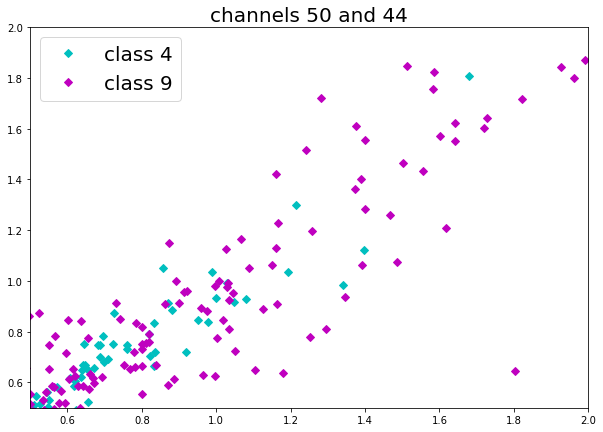

In [ ]:
ch1=50#32
ch2=44
title_='channels ' + str(ch1) + ' and ' + str(ch2)
labels_=['class '+str(i+1),'class '+str(j+1)]
plot_2D(f1[:,ch1], f1[:,ch2], f2[:,ch1], f2[:,ch2],  title_, labels_, ax=None, xlim_=(0.5,2),ylim_=(0.5,2)) # xlim and ylim are choosen such that we see better

Now the same procedure is repeated, but we take just as many samples as there are in single session (chosen randomly from all sessions), to avoid differences due to the unbalanced sets. 

train data:  (10512, 56) (10512, 9)
validation data:  (3504, 56) (3504, 9)
test data:  (3504, 56) (3504, 9)
Features size for KS test:  (3504, 56)
Labels size for KS test:  (3504, 9)
Class 1 vs class 2, best feature: 27, score 0.22378105954055322
Class 1 vs class 3, best feature: 9, score 0.2531122060363706
Class 1 vs class 4, best feature: 10, score 0.16878447596532703
Class 1 vs class 5, best feature: 23, score 0.24780769627566285
Class 1 vs class 6, best feature: 54, score 0.25479112833763995
Class 1 vs class 7, best feature: 50, score 0.31857092941998605
Class 1 vs class 8, best feature: 50, score 0.3012566137566138
Class 1 vs class 9, best feature: 50, score 0.417022792022792
Class 2 vs class 3, best feature: 14, score 0.15394878136084084
Class 2 vs class 4, best feature: 28, score 0.2809789927282521
Class 2 vs class 5, best feature: 10, score 0.21636754698353372
Class 2 vs class 6, best feature: 26, score 0.264115395937592
Class 2 vs class 7, best feature: 38, score 0.30662168617

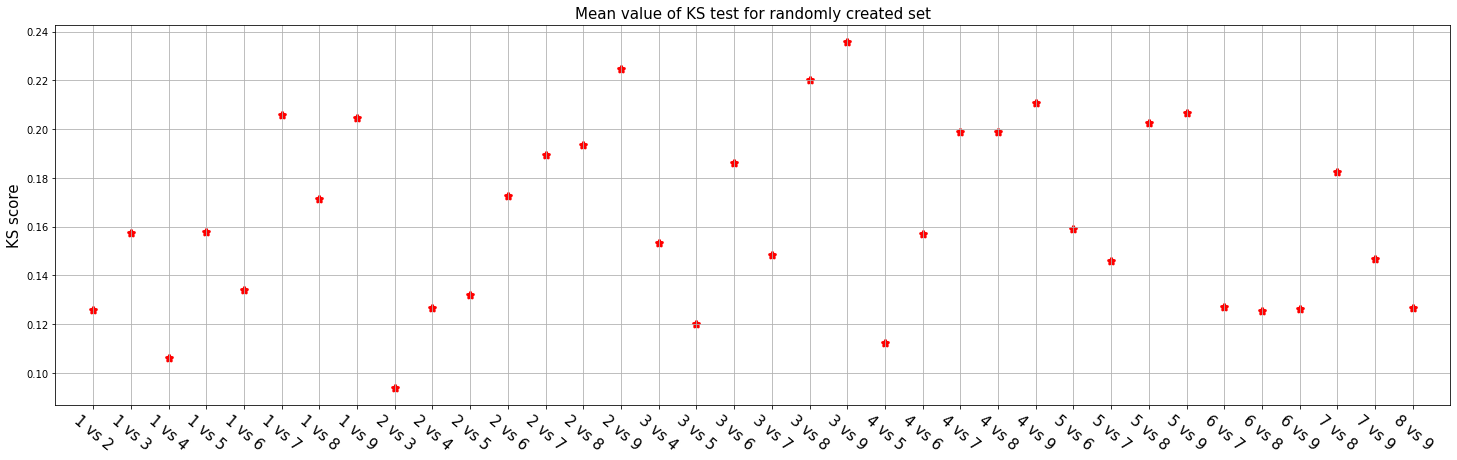

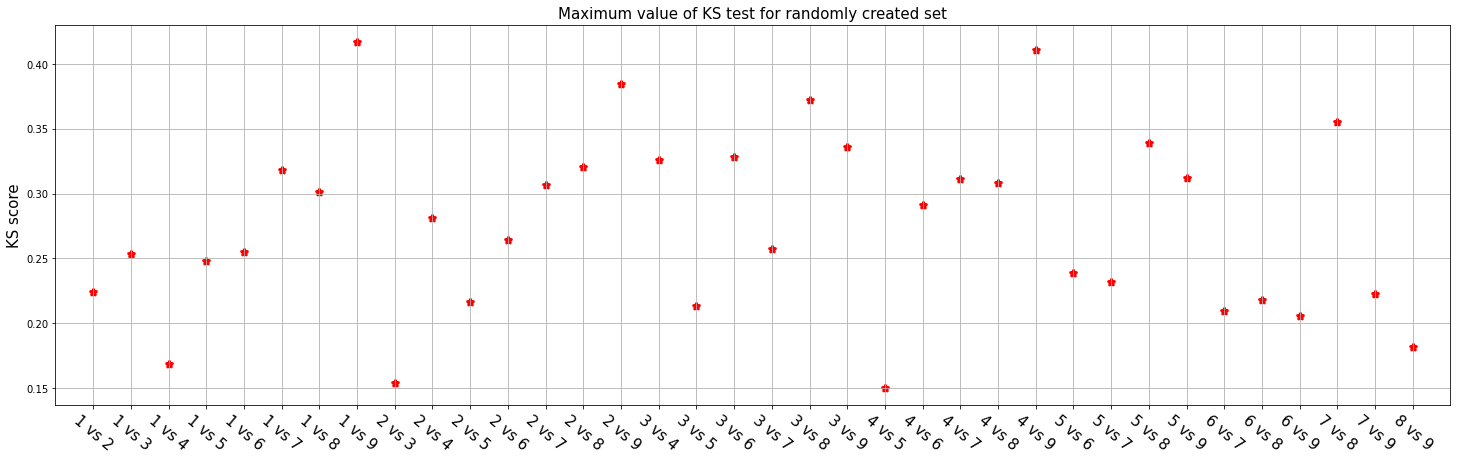

In [ ]:
session=False
reduced=False
random_selection=True
paths=create_paths(session, reduced, random_selection)
in_train, out_train, in_valid, out_valid, in_test, out_test=read_data(paths,print)

features=in_valid
labels=out_valid

print('Features size for KS test: ', np.shape(features))
print('Labels size for KS test: ', np.shape(labels))

M1=[]
M2=[]
xt=[]
cb=[]
for i in range(9):
  for j in range(9):
    if i!=j and [i,j] not in cb:
      cb.append([i,j])
      cb.append([j,i])
      l1,l2,f1,f2=create_binary(labels,features,i,j)
      KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=False, plot_=False)
      M1.append(mean_)#mean value of ks test
      M2.append(max_)#max value of KS test
      xt.append(str(i+1)+' vs ' + str(j+1))
      print('Class ' + str(i+1) + ' vs class ' + str(j+1) + ', best feature: ' + str(argmax_) + ', score ' + str(max_))

plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M1,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Mean value of KS test for randomly created set',fontsize=15)
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStestallmean.png')
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M2,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Maximum value of KS test for randomly created set',fontsize=15)
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStestallmax.png')

M1all=M1
M2all=M2

In [ ]:
#take best to plot in 2D
i=0
j=8
l1,l2,f1,f2=create_binary(labels,features,i,j)
KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=True, plot_=False)


KS1, feature number: 0 results 0.14028795278795278
p value, feature number: 0 results 0.00073080107420187

KS1, feature number: 1 results 0.1614774114774115
p value, feature number: 1 results 5.6420323298111974e-05

KS1, feature number: 2 results 0.11757224257224257
p value, feature number: 2 results 0.007619925707416764

KS1, feature number: 3 results 0.14664733414733414
p value, feature number: 3 results 0.00035195174046120936

KS1, feature number: 4 results 0.1693121693121693
p value, feature number: 4 results 1.996069668863676e-05

KS1, feature number: 5 results 0.14807183557183556
p value, feature number: 5 results 0.0002974830287580943

KS1, feature number: 6 results 0.16875254375254375
p value, feature number: 6 results 2.153504941437845e-05

KS1, feature number: 7 results 0.14697802197802198
p value, feature number: 7 results 0.0003385709737990794

KS1, feature number: 8 results 0.15888278388278387
p value, feature number: 8 results 7.872646084616797e-05

KS1, feature number: 

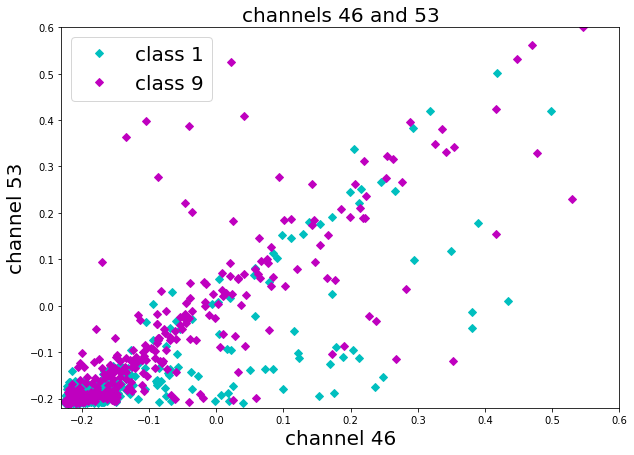

In [ ]:
ch1=46
ch2=53
title_='channels ' + str(ch1) + ' and ' + str(ch2)
labels_=['class '+str(i+1),'class '+str(j+1)]
plot_2D(f1[:,ch1], f1[:,ch2], f2[:,ch1], f2[:,ch2],  title_, labels_, ax=None, xlim_=(-0.23,0.6),ylim_=(-0.22,0.6),lx='channel '+str(ch1),ly='channel '+str(ch2))

Now we evaluate features from single session.

train data:  (10320, 56) (10320, 9)
validation data:  (3600, 56) (3600, 9)
test data:  (3600, 56) (3600, 9)
Features size for KS test:  (3600, 56)
Labels size for KS test:  (3600, 9)
Class 1 vs class 2, best feature: 10, score 0.6004079254079254
Class 1 vs class 3, best feature: 23, score 0.7361363636363636
Class 1 vs class 4, best feature: 10, score 0.36346153846153845
Class 1 vs class 5, best feature: 7, score 0.4975
Class 1 vs class 6, best feature: 52, score 0.5269230769230769
Class 1 vs class 7, best feature: 52, score 0.5125
Class 1 vs class 8, best feature: 13, score 0.5825174825174825
Class 1 vs class 9, best feature: 52, score 0.5145454545454545
Class 2 vs class 3, best feature: 43, score 0.3473076923076923
Class 2 vs class 4, best feature: 9, score 0.782051282051282
Class 2 vs class 5, best feature: 55, score 0.6818589743589744
Class 2 vs class 6, best feature: 13, score 0.9743589743589743
Class 2 vs class 7, best feature: 13, score 0.9289102564102564
Class 2 vs class 8, best

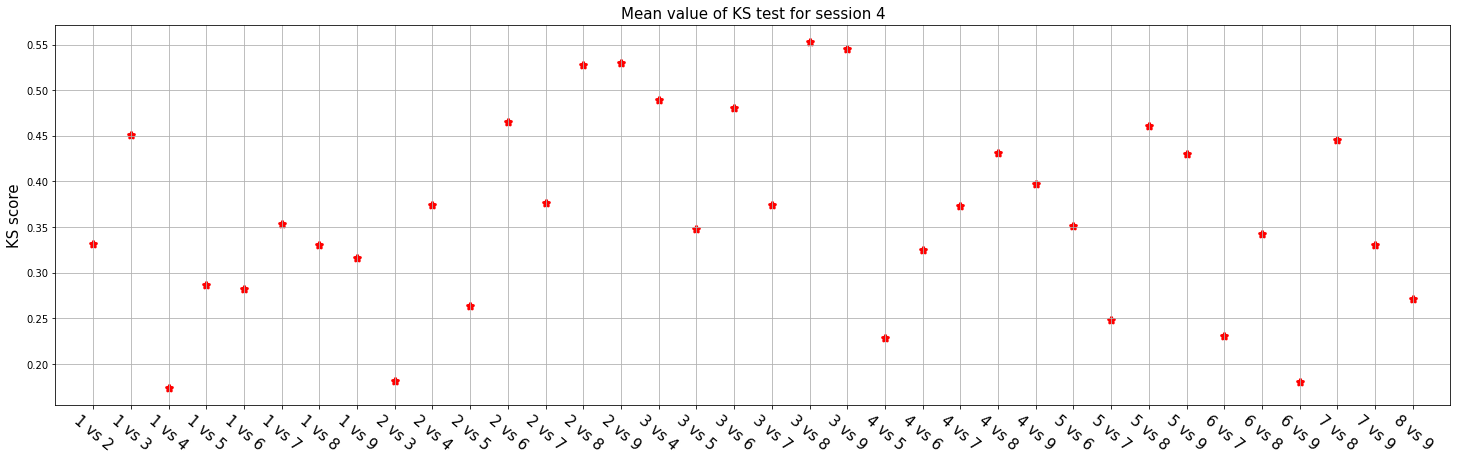

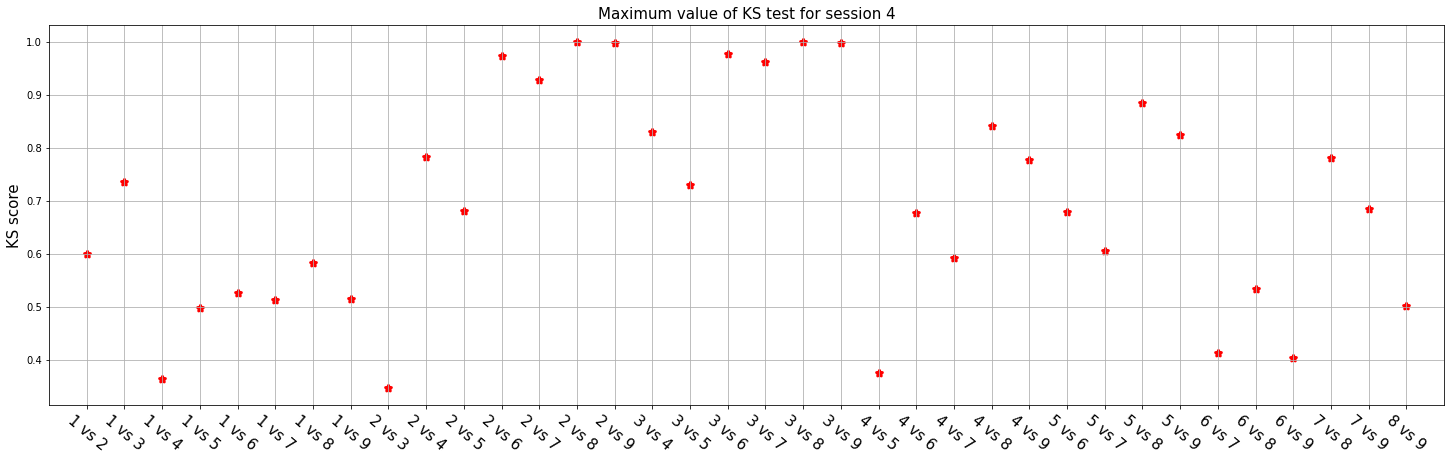

In [ ]:
session=False
reduced=False
random_selection=False
paths=create_paths(session, reduced, random_selection)
in_train, out_train, in_valid, out_valid, in_test, out_test=read_data(paths,print)

features=in_valid
labels=out_valid

print('Features size for KS test: ', np.shape(features))
print('Labels size for KS test: ', np.shape(labels))

M1=[]
M2=[]
xt=[]
cb=[]
for i in range(9):
  for j in range(9):
    if i!=j and [i,j] not in cb:
      cb.append([i,j])
      cb.append([j,i])
      l1,l2,f1,f2=create_binary(labels,features,i,j)
      KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=False, plot_=False)
      M1.append(mean_)#mean value of ks test
      M2.append(max_)#max value of KS test
      xt.append(str(i+1)+' vs ' + str(j+1))
      print('Class ' + str(i+1) + ' vs class ' + str(j+1) + ', best feature: ' + str(argmax_) + ', score ' + str(max_))

plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M1,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Mean value of KS test for session 4',fontsize=15)
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStests4mean.png')
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M2,color='r',marker="*",linewidths=3)
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Maximum value of KS test for session 4',fontsize=15)
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStests4max.png')

M1s=M1
M2s=M2

In [ ]:
#take best to plot in 2D
i=2
j=7
l1,l2,f1,f2=create_binary(labels,features,i,j)
KT, mean_, max_, argmax_ =check_discriminatory_properties(f1,f2, print_=True, plot_=False)


KS1, feature number: 0 results 0.8853205128205128
p value, feature number: 0 results 1.2212453270876722e-15

KS1, feature number: 1 results 0.6828846153846154
p value, feature number: 1 results 1.2212453270876722e-15

KS1, feature number: 2 results 0.8148717948717948
p value, feature number: 2 results 1.2212453270876722e-15

KS1, feature number: 3 results 0.9472435897435898
p value, feature number: 3 results 1.2212453270876722e-15

KS1, feature number: 4 results 0.943974358974359
p value, feature number: 4 results 1.2212453270876722e-15

KS1, feature number: 5 results 0.9546794871794871
p value, feature number: 5 results 1.2212453270876722e-15

KS1, feature number: 6 results 0.9573076923076923
p value, feature number: 6 results 1.2212453270876722e-15

KS1, feature number: 7 results 0.8760256410256411
p value, feature number: 7 results 1.2212453270876722e-15

KS1, feature number: 8 results 0.9391025641025641
p value, feature number: 8 results 1.2212453270876722e-15

KS1, feature number

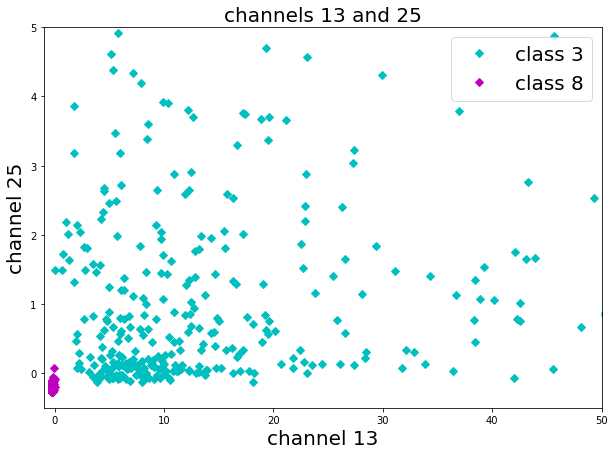

In [ ]:
ch1=13
ch2=25
title_='channels ' + str(ch1) + ' and ' + str(ch2)
labels_=['class '+str(i+1),'class '+str(j+1)]
plot_2D(f1[:,ch1], f1[:,ch2], f2[:,ch1], f2[:,ch2],  title_, labels_, ax=None, xlim_=(-1,50),ylim_=(-0.5,5),lx='channel '+str(ch1),ly='channel '+str(ch2))

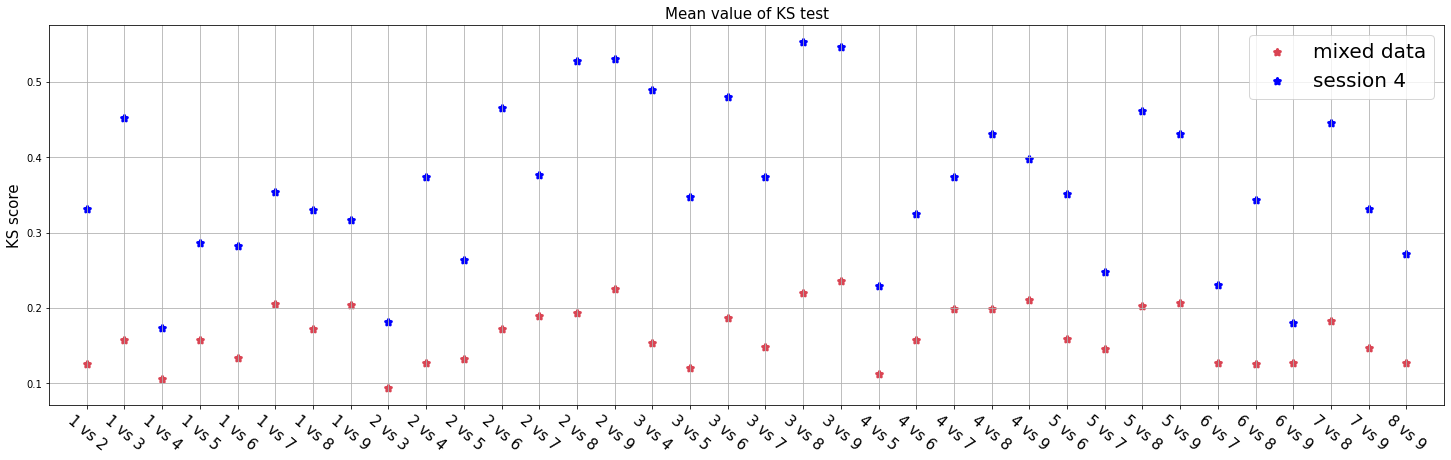

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M1all,color='#DA4453',marker="*",linewidths=3,label='mixed data')
plt.scatter(np.arange(len(M1)),M1s,color='b',marker="*",linewidths=3,label='session 4')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Mean value of KS test',fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStest_mean.png')

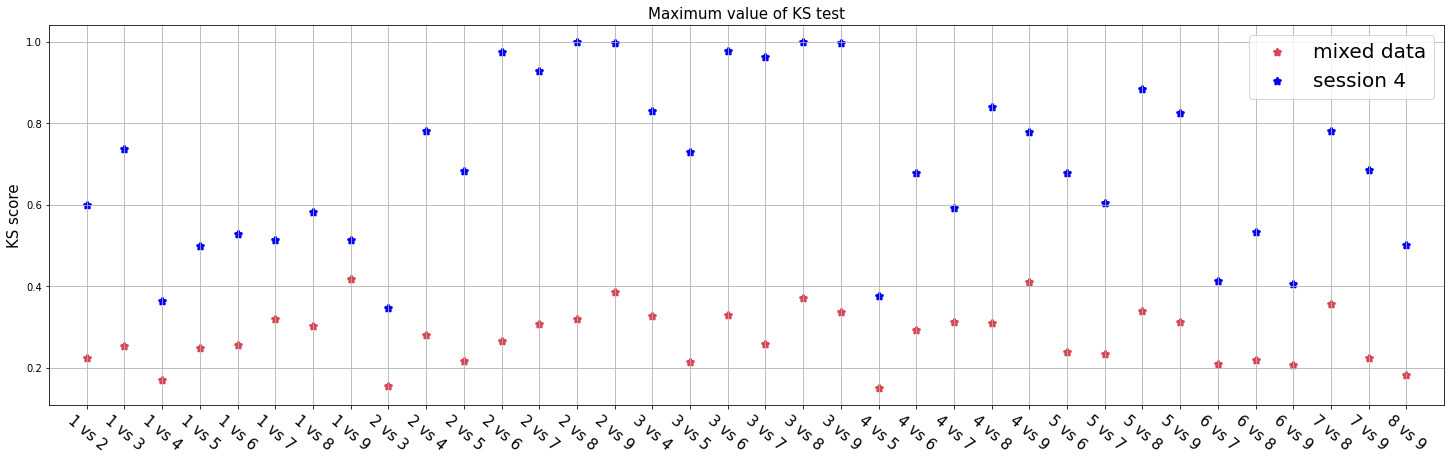

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M2all,color='#DA4453',marker="*",linewidths=3,label='mixed data')
plt.scatter(np.arange(len(M1)),M2s,color='b',marker="*",linewidths=3,label='session 4')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Maximum value of KS test',fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStest_max.png')

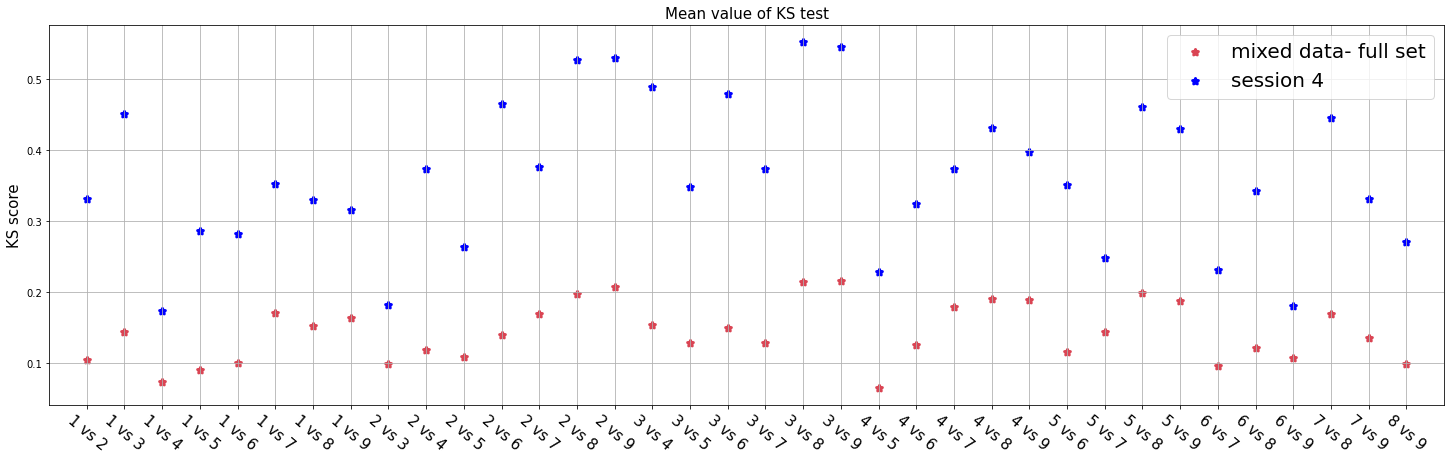

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M1all_full,color='#DA4453',marker="*",linewidths=3,label='mixed data- full set')
plt.scatter(np.arange(len(M1)),M1s,color='b',marker="*",linewidths=3,label='session 4')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Mean value of KS test',fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStest_mean_full.png')

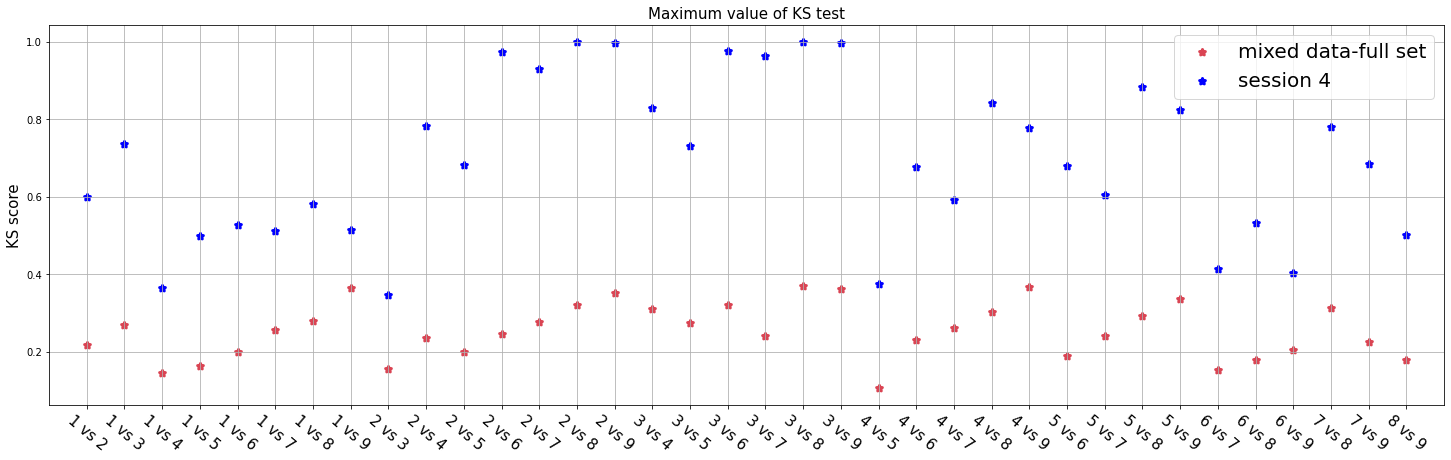

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M2all_full,color='#DA4453',marker="*",linewidths=3,label='mixed data-full set')
plt.scatter(np.arange(len(M1)),M2s,color='b',marker="*",linewidths=3,label='session 4')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Maximum value of KS test',fontsize=15)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/Shared drives/Nikolina/Results/Report figures/KStest_max_full.png')

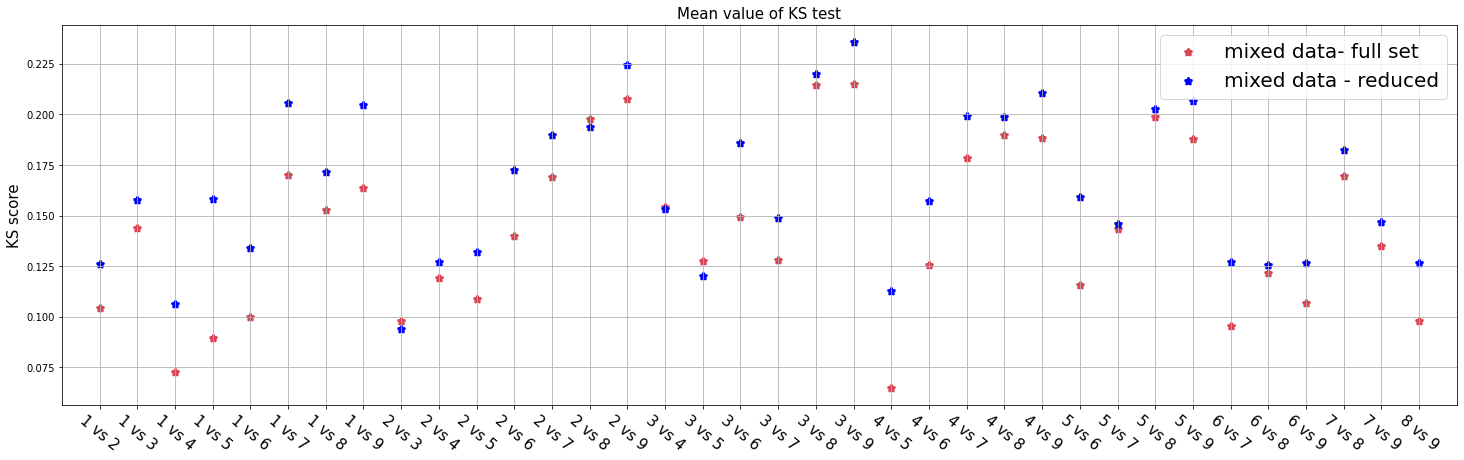

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M1all_full,color='#DA4453',marker="*",linewidths=3,label='mixed data- full set')
plt.scatter(np.arange(len(M1)),M1all,color='b',marker="*",linewidths=3,label='mixed data - reduced')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Mean value of KS test',fontsize=15)
plt.legend(prop={'size': 20})

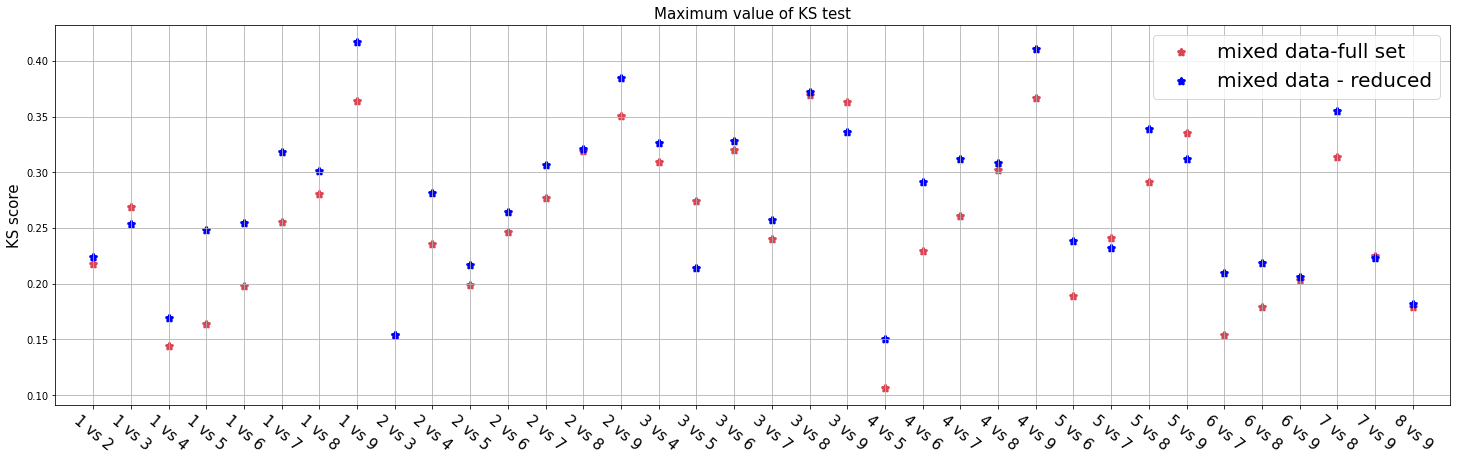

In [ ]:
plt.figure(figsize=(25,7))
plt.grid() 
plt.xlim((-1,len(M1)))
plt.scatter(np.arange(len(M1)),M2all_full,color='#DA4453',marker="*",linewidths=3,label='mixed data-full set')
plt.scatter(np.arange(len(M1)),M2all,color='b',marker="*",linewidths=3,label='mixed data - reduced')
plt.xticks(np.arange(len(M1)), xt,rotation=-40,fontsize=15)
plt.ylabel('KS score',fontsize=15)
plt.title('Maximum value of KS test',fontsize=15)
plt.legend(prop={'size': 20})